# Tarea - Clasificacion Binaria de Pinturas para Auto

In [84]:
import random
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from optbinning import BinningProcess
from optbinning import OptimalBinning

## 1 - Importación y Depuración de Datos

In [85]:
bronze_data = pd.read_excel('../Statement/datos_tarea25.xlsx')

silver_data = bronze_data.copy()  # Crear una copia del dataset original


### Binarizacion de variable objetivo

con el fin de manejar solo valores binarios en la variable objetivo definimos como 1 a White y 0 a Black

In [86]:
silver_data['Color'] = silver_data['Color'].map({'White': 1, 'Black': 0})

### Eliminar variables no representativas

El conjunto de datos no presenta variables identificadoras para eliminar pero la variable Wheel cuenta con solo dos valores de los cuales uno se lleva el 98% de las observaciones. Las RNN y espcialmente el algoritmo de maquinas de vector soporte es muy delicado a clases mal representadas por lo que eliminamos la propiedad 'Wheel' del conjunto de datos

In [87]:
silver_data = silver_data.drop(columns=['Wheel'])

### Definir tipo de datos

para cambiar las variables a el tipo de datos correcto en algunos casos tenemos que hacer algunas transformaciones sencillas. 
1. Para el caso de Mileage sacamos el sufijo 'km' de las observaciones 
2. Para el caso de 'Engine Volume' la transforme a numérica sacando la palabra 'Turbo' de done existe para poder lograr la conversion a tipo de dato numérico. Si bien es cierto que esta decision conlleva a una perdida de información la variable consta de 59 tipos de valores lo que conlleva a que ella clases mal representadas a un enorme gasto computacional porque, de ser categóricas, se transformaría en 58 variables dummys.
3. Para el caso de Airbags: la transformamos a categórica porque son solo 12 tipos de observaciones distintas y presentan saltos no lineales debido a que el aumento de los aibags suele estar relacionado con carecteristicas no lineales como el numero de pasajeros o las posiciones que se quieren asegurar 

In [88]:
# Convertir las columnas a sus tipos de datos correctos
silver_data['Mileage'] = silver_data['Mileage'].str.replace(' km', '').str.replace(',', '').astype(float)  # Convertir Mileage a numérico
silver_data['Engine volume'] = silver_data['Engine volume'].str.replace(' Turbo', '').astype(float)  # Convertir Engine volume a numérico
silver_data['Airbags'] = silver_data['Airbags'].astype('category')


Para el caso de la variable Levy decidimos tramificar debido a que hay pocas clases que concentran la mayoría de las observaciones y la gran cantidad de datos perdidos.

Para poder definir los tramos que mejor separen las observaciones en base a la variable objetivo 'Color'. El indice que utilizamos es el 'Information Value' usando como criterio un valor mínimo de 0.02 de información por cada tramo y un máximo de 5 tramos. 

Debido a que esta variable presentaba un 15% de datos perdidos decidimos añadir una sexta categoría que represente a todos los datos perdidos de manera que podamos captar la información que quizás la ausencia de valor para esa variable puede significar

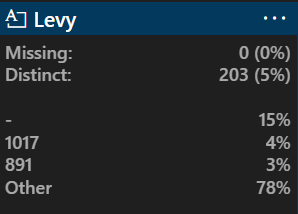

In [89]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Reemplazar "-" por NaN y convertir a numérico
silver_data['Levy'] = silver_data['Levy'].replace("-", np.nan)
silver_data['Levy'] = pd.to_numeric(silver_data['Levy'], errors='coerce')

# Excluir valores nulos de Levy para el binning
non_null_data = silver_data[silver_data['Levy'].notnull()]

# Configurar el proceso de binning con el criterio de Information Value (IV)
binning_process = BinningProcess(
    variable_names=['Levy'],
    selection_criteria={"iv": {"min": 0.02}},
    max_n_bins=5  # Máximo número de bins permitido
)

# Ajustar el binning process a los datos no nulos
binning_process.fit(non_null_data[['Levy']], non_null_data['Color'])

# Obtener los puntos de corte (splits)
levy_binned = binning_process.get_binned_variable('Levy')
binning_table = levy_binned.binning_table
binning_table.build()
levy_splits = binning_table.splits

# Crear etiquetas personalizadas para los tramos
levy_bins_labels = [f"{float(lower)} - {float(upper)}" for lower, upper in zip([-float('inf')] + list(levy_splits), list(levy_splits) + [float('inf')])]

# Asignar las etiquetas personalizadas a los tramos
silver_data['Levy_bins'] = pd.cut(
    silver_data['Levy'],
    bins=[-float('inf')] + list(levy_splits) + [float('inf')],
    labels=levy_bins_labels,
    right=False
)

# Añadir un tramo específico para los valores nulos
silver_data['Levy_bins'] = silver_data['Levy_bins'].cat.add_categories("Missing")
silver_data['Levy_bins'].fillna("Missing", inplace=True)
silver_data = silver_data.drop(columns=['Levy'])

Para el caso de la variable 'Prod. year' quisimos también hacer una tramificación usando el Information value como criterio para encontrar los puntos de corte optimo pero después de mucho intentar parece haber un problema insalvable con los datos de la variable para poder ser tratados por la función que obtiene los tramos adecuados. 

Frente a esto y la conveniencia de tramificar ya que es una variable que es susceptible de tener saltos no lineales con respecto a la variable objetivo (por ejemplo una regulación que a partir de cierto año en la UE se promueve los autos blancos) decidimos tramificar la variable de manera manual, agrupando los poco autos viejos que había en el primer tramo y tener tramos mas pequeños de ahi en adelante. 

Debido a que la tramificación en este caso no era una decision tan obvia y es cuestionable decidimos mantener también la variable original de manera numérica en el conjunto de datos

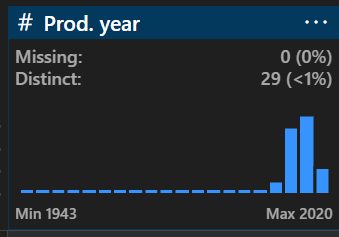

In [90]:
silver_data['Prod. year'] = pd.to_numeric(bronze_data['Prod. year'])

# Crear tramos manuales para 'Prod. year'
manual_bins = [1943, 2000, 2004, 2008, 2012, 2016, 2020]
manual_labels = ['1943-2000', '2001-2004', '2005-2008', '2009-2012', '2013-2016', '2017-2020']

# Asignar los tramos manuales a la columna 'Prod. year'
silver_data['Prod. year_bins'] = pd.cut(
    silver_data['Prod. year'],
    bins=manual_bins,
    labels=manual_labels,
    right=True,
    include_lowest=True 
)


### Tratamiento de valores missings

Para el caso de las variables categóricas imputamos en los valores perdidos la moda de cada variable. Para el caso de las variables numéricas imputamos el promedio en cada variable. Este cambio aplica para todas las demás variables que no fuero tratadas de manera especifica en los pasos previos

In [91]:
for column in silver_data.columns:
    if silver_data[column].dtype == 'object':  # Imputar moda para variables categóricas
        silver_data[column].fillna(silver_data[column].mode()[0], inplace=True)
    elif silver_data[column].dtype in ['int64', 'float64']:  # Imputar promedio para variables numéricas
        silver_data[column].fillna(silver_data[column].mean(), inplace=True)

### Valores dummies para cada variable categorica

Para cada variable categorica de nuestro conjunto de datos creamos n-1 variables diferentes siendo n el numero total de valores diferentes de la variable categorica en cuestion. 

In [92]:
# 2. Crear columnas dummys para variables categóricas

silver_data = pd.get_dummies(silver_data, columns=silver_data.drop(columns=['Color']).select_dtypes(include=['object']).columns, drop_first=True)

### Estandarización de variables continuas

Para mejorar la capacidad explicativa de las variables continuas en las RNN es importante estandarizarlas a todas aplicándoles la misma transformación. En este caso aplicamos la estandarización a escala, es decir las variables van a ir de 0 a 1. 

Si bien es cierto que esta transformación es menor fiel del punto de vista explicativo a la escala original que la transformación normal decidimos aplicar esta transformación porque es mejor para los fines predictivos y los RNN, al ser modelos de caja negra, adolecen, en gran medida, de capacidad explicativa mas no de su uso predictivo

In [93]:
# 3. Estandarizar variables continuas a escala [0, 1]
scaler = MinMaxScaler()
numerical_columns = silver_data.select_dtypes(include=['int64', 'float64']).columns
silver_data[numerical_columns] = scaler.fit_transform(silver_data[numerical_columns])

## 2 - Modelización con maquina de vector soporte

Dividimos los conjuntos de datos para train y test usando una semilla de aleatoriedad prefijada

In [94]:
Y = silver_data['Color'] 
X = silver_data.drop(columns=['Color'])
print("Variables explicativas: ", list(X.columns))
print("Variable objetivo: ", Y.name)

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=SEED)

Variables explicativas:  ['Price', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Levy_bins', 'Prod. year_bins', 'Manufacturer_LEXUS', 'Manufacturer_MERCEDES-BENZ', 'Manufacturer_TOYOTA', 'Category_Jeep', 'Category_Sedan', 'Leather interior_Yes', 'Fuel type_Hybrid', 'Fuel type_Petrol', 'Gear box type_Tiptronic', 'Drive wheels_Front', 'Drive wheels_Rear']
Variable objetivo:  Color
